In [3]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
df_ratings = pd.read_csv('/home/eduardo/PycharmProjects/Rec_Sys_/dataset/ml-latest-small/ratings.csv', sep=',')
df_movies = pd.read_csv('/home/eduardo/PycharmProjects/Rec_Sys_/dataset/ml-latest-small//movies.csv')

In [14]:
df_user_item = pd.merge(df_ratings, df_movies, on='movieId', how='inner')

In [15]:
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(df_user_item[c].unique())
    df_user_item[c] = d[c].transform(df_user_item[c])

In [16]:
df_train = df_user_item.groupby('userId').head(-5).reset_index(drop=True)
df_val = df_user_item.groupby('userId').tail(5).reset_index(drop=True)

In [ ]:
# class MovieDataset(Dataset):
#     def __init__(self, df):
#         super().__init__()
#         self.df = df[['userId', 'movieId', 'rating']]
#         self.x_user_movie = list(zip(df.userId.values, df.movieId.values))
#         self.y_rating = self.df.rating.values
# 
#     def __len__(self):
#         return len(self.df)
# 
#     def __getitem__(self, idx):
#         return self.x_user_movie[idx], self.y_rating[idx]
# 
# 
# BS = 8192
# ds_train = MovieDataset(df_train)(df_train)
# ds_val = MovieDataset(df_val)
# dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=4)
# dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=4)
# 
# xb, yb = next(iter(dl_train))
# print(xb)
# ds_val = MovieDataset(df_val)
# dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=4)
# dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=4)
# 
# xb, yb = next(iter(dl_train))
# print(xb)
# print(yb)

In [150]:
matrix = df_user_item[['userId', 'movieId', 'rating']]
X = list(zip(matrix.userId.values, matrix.movieId.values))
y = matrix.rating.values
data_t = torch.tensor(X)
labels = torch.tensor(y)
# labels = labels[:, None]

In [151]:
batch_size = 32

# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_t, labels, test_size=.1)

#convert to a pytorch 
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# train and test dataloaders
train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

In [152]:
train_labels.shape

torch.Size([90752])

In [153]:
def sigmoid_range(x, low, high):
    return torch.sigmoid(x) * (high - low) + low

In [171]:
class MF(nn.Module):

    def __init__(self, num_users, num_items, emb_dim, init, bias, sigmoid):
        super().__init__()
        self.bias = bias
        self.sigmoid = sigmoid
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)

        # add bias
        if bias:
            self.user_bias = nn.Parameter(torch.zeros(num_users))
            self.item_bias = nn.Parameter(torch.zeros(num_items))
            self.offset = nn.Parameter(torch.zeros(1))
        if init:
            self.user_emb.weight.data.uniform_(0., 0.5)
            self.item_emb.weight.data.uniform_(0., 0.5)

    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb * item_emb).sum(1)
        if self.bias:
            user_b = self.user_bias[user]
            item_b = self.item_bias[item]
            element_product += user_b + item_b + self.offset
        if self.sigmoid:
            return sigmoid_range(element_product, 0, 5.5)
        return (user_emb * item_emb).sum(1).float()


n_users = len(df_user_item.userId.unique())
n_items = len(df_user_item.movieId.unique())
mf_model = MF(n_users, n_items, emb_dim=32, init=True, bias=True, sigmoid=True)
mf_model.to(device)
print(mf_model)

MF(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)


In [172]:
def rout_to_0p5(list_nums):
    return np.round(np.array(list_nums) * 2) / 2

In [173]:
# train the model

def train_model(num_epochs):
    loss_fun = nn.MSELoss()
    optimizer = optim.SGD(mf_model.parameters(), lr=.01)
    # initialize accuracies as empties
    train_losses = []
    val_losses = []

    # loop over epochs
    for epoch in range(num_epochs):

        # activate training mode
        mf_model.train()

        # loop over training data batches
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            user, item = X[:, 0], X[:, 1]
            y_ratings = y.to(device, dtype=torch.float)
            y_hat = mf_model(user, item)
            loss = loss_fun(y_hat, y_ratings)

            # backproptestAcc
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        # append the batch loss 
        train_losses.append(np.mean(batchLoss))

        # activate testing mode
        mf_model.eval()

        # extract X,y from test dataloader
        X, y = next(iter(test_loader))
        user_val, item_val = X[:, 0], X[:, 1]
        with torch.no_grad():
            y_hat = mf_model(user_val, item_val)
            loss = loss_fun(y_hat, y)
        val_losses.append(loss)

    # function output
    return train_losses, val_losses


In [177]:
train_losses, val_losses = train_model(num_epochs=10)

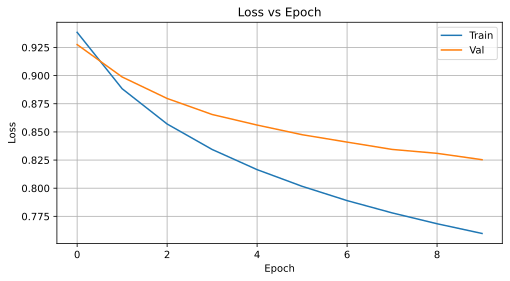

In [178]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();


In [ ]:
user_emb_min_w = mdl.user_emb.weight.min().item()
user_emb_max_w = mdl.user_emb.weight.max().item()
item_emb_min_w = mdl.item_emb.weight.min().item()
item_emb_max_w = mdl.item_emb.weight.max().item()

print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])

In [ ]:
# Example data
data = [
    ['A', 'X'],
    ['B', 'Y'],
    ['C', 'Z'],
    ['A', 'Y'],
    ['B', 'X']
]
data
# Transform two columns into a new unique index
label_encoder = LabelEncoder()
encoded_data = label_encoder.fit_transform(data)

# Print the encoded data
print("Encoded data:", encoded_data)

# Inverse transform to get back to the original structure
original_data = label_encoder.inverse_transform(encoded_data)

# Print the original data
print("Original data:", original_data)